[View in Colaboratory](https://colab.research.google.com/github/ozanpekmezci/capstone/blob/master/multi_digit_recognition_svhn.ipynb)

# Multi Digit Number Recognition with SVHN

This notebook implements multi digit number recognition using SVHN dataset that will be used to recognize house numbers at the streets. It can be considered as second version of the previous multi digit recognition which uses MNIST database. Keras and Tensorflow libraries are used to build the recognizer.
This recognizer extracts digit from the image using Convolutional Neural Network Classifier.

In [0]:
# Module Imports
from __future__ import print_function
import random
from os import listdir
import glob

import numpy as np
from scipy import misc
import tensorflow as tf
import h5py

from keras.datasets import mnist
from keras.utils import np_utils

from six.moves import cPickle as pickle
from six.moves import range


import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Setting the random seed so that the results are reproducible. 
random.seed(42)

# Setting variables for MNIST image dimensions
mnist_image_height = 28
mnist_image_width = 28

## Load Dataset

In [21]:
pickle_file = 'SVHN_multi_crop.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (27401, 64, 64) (27401, 5)
Validation set (6000, 64, 64) (6000, 5)
Test set (13068, 64, 64) (13068, 5)


Label for image: [ 7  5 10 10 10]


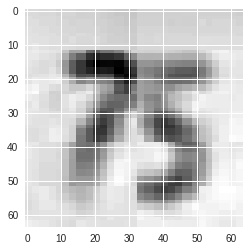

In [22]:
plt.figure()
plt.imshow(train_dataset[50], cmap='gray')

print("Label for image: {}".format(train_labels[50]))

## Convert Labels
This function converts each digit label to one-hot array.

In [0]:
# Converting labels to One-hot representations of shape (set_size, digits, classes)
possible_classes = 11

def convert_labels(labels):
    
    # As per Keras conventions, the multiple labels need to be of the form [array_digit1,...5]
    # Each digit array will be of shape (60000,11)
        
    # Declare output ndarrays
    # 5 for digits, 11 for possible classes  
    dig0_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig1_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig2_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig3_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig4_arr = np.ndarray(shape=(len(labels),possible_classes))
    
    for index,label in enumerate(labels):
        
        # Using np_utils from keras to OHE the labels in the image
        dig0_arr[index,:] = np_utils.to_categorical(label[0],possible_classes)
        dig1_arr[index,:] = np_utils.to_categorical(label[1],possible_classes)
        dig2_arr[index,:] = np_utils.to_categorical(label[2],possible_classes)
        dig3_arr[index,:] = np_utils.to_categorical(label[3],possible_classes)
        dig4_arr[index,:] = np_utils.to_categorical(label[4],possible_classes)
        
    return [dig0_arr,dig1_arr,dig2_arr,dig3_arr,dig4_arr]

In [0]:
train_labels = convert_labels(train_labels)
test_labels = convert_labels(test_labels)

In [24]:
# Checking the shape of the OHE array for the first digit position
np.shape(train_labels[0])

(27401, 11)

## Prepare Data for Keras
Reshape image data to be processed by Keras.

In [0]:
def prep_data_keras(img_data):
    
    # Reshaping data for keras, with tensorflow as backend
    img_data = img_data.reshape(len(img_data), 64, 64, 1)
    
    # Converting everything to floats
    img_data = img_data.astype('float32')
    
    # Normalizing values between 0 and 1
    img_data /= 255
    
    return img_data


In [0]:
train_images = prep_data_keras(train_dataset)
test_images = prep_data_keras(test_dataset)

In [29]:
np.shape(train_images)

(27401, 64, 64, 1)

In [30]:
np.shape(test_images)

(13068, 64, 64, 1)

In [0]:
# Importing relevant keras modules
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

## Build Model
Build Deep Learning model to process data.

In [32]:
# Building the model

batch_size = 128
nb_classes = 11
nb_epoch = 12

# image input dimensions
img_rows = 64
img_cols = 64
img_channels = 1

# number of convulation filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# defining the input
inputs = Input(shape=(img_rows, img_cols, img_channels))

# Model taken from keras example.
cov = Convolution2D(nb_filters,kernel_size[0],kernel_size[1],border_mode='same')(inputs)
cov = Activation('relu')(cov)
cov = Convolution2D(nb_filters,kernel_size[0],kernel_size[1])(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.25)(cov)
cov_out = Flatten()(cov)


# Dense Layers
cov2 = Dense(128, activation='relu')(cov_out)
cov2 = Dropout(0.5)(cov2)



# Prediction layers
c0 = Dense(nb_classes, activation='softmax')(cov2)
c1 = Dense(nb_classes, activation='softmax')(cov2)
c2 = Dense(nb_classes, activation='softmax')(cov2)
c3 = Dense(nb_classes, activation='softmax')(cov2)
c4 = Dense(nb_classes, activation='softmax')(cov2)

# Defining the model
model = Model(input=inputs,output=[c0,c1,c2,c3,c4])

# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Fitting the model
model.fit(train_images,train_labels,batch_size=batch_size,nb_epoch=nb_epoch,verbose=1,
          validation_data=(test_images, test_labels))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:45: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:52: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 27401 samples, validate on 13068 samples
Epoch 1/12
27401/27401 [==============================] - 20s 713us/step - loss: 6.2632 - dense_2_loss: 2.1755 - dense_3_loss: 2.3347 - dense_4_loss: 1.2991 - dense_5_loss: 0.3419 - dense_6_loss: 0.1120 - dense_2_acc: 0.2310 - dense_3_acc: 0.2088 - dense_4_acc: 0.7210 - dense_5_acc: 0.9574 - dense_6_acc: 0.9954 - val_loss: 4.9861 - val_dense_2_loss: 2.0040 - val_dense_3_loss: 2.1539 - val_dense_4_loss: 0.7513 - val_dense_5_loss: 0.0731 - val_dense_6_loss: 0.0039 - val_dense_2_acc: 0.2827 - val_dense_3_acc: 0.2971 - val_dense_4_acc: 0.8521 - val_dense_5_acc: 0.9909 - val_dense_6_acc: 0.9999
Epoch 2/12
 1664/27401 [>.............................] - ETA: 13s - loss: 5.8749 - dense_2_loss: 2.1054 - dense_3_loss: 2.2630 - dense_4_loss: 1.1866 - dense_5_loss: 0.2971 - dense_6_loss: 0.0228 - dense_2_acc: 0.2422 - dense_3_acc: 0.2404 - dense_4_acc: 0.7470 - dense_5_acc: 0.9597 - dense_6_acc: 1.0000

27401/27401 [==============================] - 16s 602us/step - loss: 5.7926 - dense_2_loss: 2.0638 - dense_3_loss: 2.2417 - dense_4_loss: 1.2085 - dense_5_loss: 0.2626 - dense_6_loss: 0.0160 - dense_2_acc: 0.2555 - dense_3_acc: 0.2488 - dense_4_acc: 0.7343 - dense_5_acc: 0.9632 - dense_6_acc: 0.9998 - val_loss: 5.0051 - val_dense_2_loss: 2.0029 - val_dense_3_loss: 2.1549 - val_dense_4_loss: 0.7658 - val_dense_5_loss: 0.0778 - val_dense_6_loss: 0.0036 - val_dense_2_acc: 0.2827 - val_dense_3_acc: 0.2971 - val_dense_4_acc: 0.8521 - val_dense_5_acc: 0.9909 - val_dense_6_acc: 0.9999
Epoch 3/12
 4352/27401 [===>..........................] - ETA: 12s - loss: 5.7347 - dense_2_loss: 2.0435 - dense_3_loss: 2.2481 - dense_4_loss: 1.1857 - dense_5_loss: 0.2473 - dense_6_loss: 0.0102 - dense_2_acc: 0.2682 - dense_3_acc: 0.2429 - dense_4_acc: 0.7387 - dense_5_acc: 0.9653 - dense_6_acc: 1.0000

27401/27401 [==============================] - 17s 603us/step - loss: 5.7291 - dense_2_loss: 2.0441 - dense_3_loss: 2.2231 - dense_4_loss: 1.1951 - dense_5_loss: 0.2567 - dense_6_loss: 0.0101 - dense_2_acc: 0.2704 - dense_3_acc: 0.2534 - dense_4_acc: 0.7343 - dense_5_acc: 0.9632 - dense_6_acc: 0.9998 - val_loss: 5.0945 - val_dense_2_loss: 2.0099 - val_dense_3_loss: 2.1602 - val_dense_4_loss: 0.8226 - val_dense_5_loss: 0.0963 - val_dense_6_loss: 0.0055 - val_dense_2_acc: 0.2827 - val_dense_3_acc: 0.2971 - val_dense_4_acc: 0.8521 - val_dense_5_acc: 0.9909 - val_dense_6_acc: 0.9999
Epoch 4/12
 5504/27401 [=====>........................] - ETA: 11s - loss: 5.6323 - dense_2_loss: 2.0627 - dense_3_loss: 2.2060 - dense_4_loss: 1.1500 - dense_5_loss: 0.2071 - dense_6_loss: 0.0065 - dense_2_acc: 0.2654 - dense_3_acc: 0.2573 - dense_4_acc: 0.7382 - dense_5_acc: 0.9695 - dense_6_acc: 0.9998

27401/27401 [==============================] - 16s 600us/step - loss: 5.5760 - dense_2_loss: 2.0439 - dense_3_loss: 2.1891 - dense_4_loss: 1.1049 - dense_5_loss: 0.2294 - dense_6_loss: 0.0087 - dense_2_acc: 0.2740 - dense_3_acc: 0.2534 - dense_4_acc: 0.7343 - dense_5_acc: 0.9632 - dense_6_acc: 0.9998 - val_loss: 4.7828 - val_dense_2_loss: 1.9982 - val_dense_3_loss: 2.0879 - val_dense_4_loss: 0.6337 - val_dense_5_loss: 0.0611 - val_dense_6_loss: 0.0020 - val_dense_2_acc: 0.2827 - val_dense_3_acc: 0.2971 - val_dense_4_acc: 0.8521 - val_dense_5_acc: 0.9909 - val_dense_6_acc: 0.9999
Epoch 5/12
 6400/27401 [======>.......................] - ETA: 11s - loss: 5.3763 - dense_2_loss: 2.0161 - dense_3_loss: 2.1421 - dense_4_loss: 1.0098 - dense_5_loss: 0.2017 - dense_6_loss: 0.0066 - dense_2_acc: 0.2822 - dense_3_acc: 0.2528 - dense_4_acc: 0.7344 - dense_5_acc: 0.9656 - dense_6_acc: 1.0000

27401/27401 [==============================] - 16s 601us/step - loss: 5.2826 - dense_2_loss: 1.9719 - dense_3_loss: 2.1199 - dense_4_loss: 0.9773 - dense_5_loss: 0.2057 - dense_6_loss: 0.0079 - dense_2_acc: 0.2992 - dense_3_acc: 0.2486 - dense_4_acc: 0.7343 - dense_5_acc: 0.9632 - dense_6_acc: 0.9998 - val_loss: 4.4588 - val_dense_2_loss: 1.8442 - val_dense_3_loss: 2.0121 - val_dense_4_loss: 0.5493 - val_dense_5_loss: 0.0522 - val_dense_6_loss: 9.1344e-04 - val_dense_2_acc: 0.3980 - val_dense_3_acc: 0.2916 - val_dense_4_acc: 0.8521 - val_dense_5_acc: 0.9909 - val_dense_6_acc: 0.9999
Epoch 6/12
 5632/27401 [=====>........................] - ETA: 11s - loss: 5.1251 - dense_2_loss: 1.8578 - dense_3_loss: 2.0870 - dense_4_loss: 0.9590 - dense_5_loss: 0.2137 - dense_6_loss: 0.0076 - dense_2_acc: 0.3635 - dense_3_acc: 0.2468 - dense_4_acc: 0.7237 - dense_5_acc: 0.9592 - dense_6_acc: 0.9998

27401/27401 [==============================] - 17s 604us/step - loss: 4.9214 - dense_2_loss: 1.7910 - dense_3_loss: 2.0200 - dense_4_loss: 0.9142 - dense_5_loss: 0.1895 - dense_6_loss: 0.0068 - dense_2_acc: 0.3883 - dense_3_acc: 0.2808 - dense_4_acc: 0.7345 - dense_5_acc: 0.9632 - dense_6_acc: 0.9998 - val_loss: 4.3645 - val_dense_2_loss: 1.6781 - val_dense_3_loss: 1.9076 - val_dense_4_loss: 0.6976 - val_dense_5_loss: 0.0780 - val_dense_6_loss: 0.0032 - val_dense_2_acc: 0.4408 - val_dense_3_acc: 0.3725 - val_dense_4_acc: 0.8521 - val_dense_5_acc: 0.9909 - val_dense_6_acc: 0.9999
Epoch 7/12
 6144/27401 [=====>........................] - ETA: 11s - loss: 4.7859 - dense_2_loss: 1.7315 - dense_3_loss: 1.9660 - dense_4_loss: 0.8918 - dense_5_loss: 0.1887 - dense_6_loss: 0.0079 - dense_2_acc: 0.4098 - dense_3_acc: 0.3086 - dense_4_acc: 0.7432 - dense_5_acc: 0.9634 - dense_6_acc: 0.9997

27401/27401 [==============================] - 17s 606us/step - loss: 4.6936 - dense_2_loss: 1.6822 - dense_3_loss: 1.9262 - dense_4_loss: 0.8930 - dense_5_loss: 0.1856 - dense_6_loss: 0.0066 - dense_2_acc: 0.4282 - dense_3_acc: 0.3221 - dense_4_acc: 0.7351 - dense_5_acc: 0.9632 - dense_6_acc: 0.9998 - val_loss: 3.8900 - val_dense_2_loss: 1.5633 - val_dense_3_loss: 1.7347 - val_dense_4_loss: 0.5379 - val_dense_5_loss: 0.0532 - val_dense_6_loss: 9.6880e-04 - val_dense_2_acc: 0.4917 - val_dense_3_acc: 0.4075 - val_dense_4_acc: 0.8522 - val_dense_5_acc: 0.9909 - val_dense_6_acc: 0.9999
Epoch 8/12
 5760/27401 [=====>........................] - ETA: 11s - loss: 4.5855 - dense_2_loss: 1.6405 - dense_3_loss: 1.8737 - dense_4_loss: 0.8798 - dense_5_loss: 0.1870 - dense_6_loss: 0.0046 - dense_2_acc: 0.4453 - dense_3_acc: 0.3385 - dense_4_acc: 0.7365 - dense_5_acc: 0.9628 - dense_6_acc: 1.0000

27401/27401 [==============================] - 17s 603us/step - loss: 4.5258 - dense_2_loss: 1.6107 - dense_3_loss: 1.8566 - dense_4_loss: 0.8722 - dense_5_loss: 0.1801 - dense_6_loss: 0.0062 - dense_2_acc: 0.4556 - dense_3_acc: 0.3521 - dense_4_acc: 0.7362 - dense_5_acc: 0.9632 - dense_6_acc: 0.9998 - val_loss: 3.7411 - val_dense_2_loss: 1.4976 - val_dense_3_loss: 1.6778 - val_dense_4_loss: 0.5118 - val_dense_5_loss: 0.0526 - val_dense_6_loss: 0.0013 - val_dense_2_acc: 0.5034 - val_dense_3_acc: 0.4327 - val_dense_4_acc: 0.8528 - val_dense_5_acc: 0.9909 - val_dense_6_acc: 0.9999
Epoch 9/12
 5888/27401 [=====>........................] - ETA: 11s - loss: 4.4012 - dense_2_loss: 1.5669 - dense_3_loss: 1.8264 - dense_4_loss: 0.8477 - dense_5_loss: 0.1558 - dense_6_loss: 0.0044 - dense_2_acc: 0.4594 - dense_3_acc: 0.3697 - dense_4_acc: 0.7395 - dense_5_acc: 0.9681 - dense_6_acc: 0.9998

27401/27401 [==============================] - 17s 602us/step - loss: 4.3941 - dense_2_loss: 1.5472 - dense_3_loss: 1.8076 - dense_4_loss: 0.8548 - dense_5_loss: 0.1783 - dense_6_loss: 0.0061 - dense_2_acc: 0.4720 - dense_3_acc: 0.3713 - dense_4_acc: 0.7378 - dense_5_acc: 0.9632 - dense_6_acc: 0.9998 - val_loss: 3.6350 - val_dense_2_loss: 1.4487 - val_dense_3_loss: 1.6184 - val_dense_4_loss: 0.5132 - val_dense_5_loss: 0.0536 - val_dense_6_loss: 0.0012 - val_dense_2_acc: 0.5116 - val_dense_3_acc: 0.4803 - val_dense_4_acc: 0.8533 - val_dense_5_acc: 0.9909 - val_dense_6_acc: 0.9999
Epoch 10/12
 5504/27401 [=====>........................] - ETA: 11s - loss: 4.3414 - dense_2_loss: 1.5233 - dense_3_loss: 1.7722 - dense_4_loss: 0.8568 - dense_5_loss: 0.1832 - dense_6_loss: 0.0060 - dense_2_acc: 0.4807 - dense_3_acc: 0.3866 - dense_4_acc: 0.7398 - dense_5_acc: 0.9617 - dense_6_acc: 1.0000

27401/27401 [==============================] - 17s 605us/step - loss: 4.2869 - dense_2_loss: 1.4975 - dense_3_loss: 1.7651 - dense_4_loss: 0.8399 - dense_5_loss: 0.1780 - dense_6_loss: 0.0065 - dense_2_acc: 0.4891 - dense_3_acc: 0.3863 - dense_4_acc: 0.7395 - dense_5_acc: 0.9631 - dense_6_acc: 0.9998 - val_loss: 3.5708 - val_dense_2_loss: 1.4178 - val_dense_3_loss: 1.5840 - val_dense_4_loss: 0.5141 - val_dense_5_loss: 0.0534 - val_dense_6_loss: 0.0014 - val_dense_2_acc: 0.5139 - val_dense_3_acc: 0.4859 - val_dense_4_acc: 0.8566 - val_dense_5_acc: 0.9909 - val_dense_6_acc: 0.9999
Epoch 11/12
 5888/27401 [=====>........................] - ETA: 11s - loss: 4.2517 - dense_2_loss: 1.4650 - dense_3_loss: 1.7501 - dense_4_loss: 0.8493 - dense_5_loss: 0.1801 - dense_6_loss: 0.0073 - dense_2_acc: 0.5032 - dense_3_acc: 0.3849 - dense_4_acc: 0.7364 - dense_5_acc: 0.9614 - dense_6_acc: 0.9998

27401/27401 [==============================] - 17s 605us/step - loss: 4.1830 - dense_2_loss: 1.4510 - dense_3_loss: 1.7250 - dense_4_loss: 0.8275 - dense_5_loss: 0.1731 - dense_6_loss: 0.0065 - dense_2_acc: 0.5056 - dense_3_acc: 0.4016 - dense_4_acc: 0.7440 - dense_5_acc: 0.9631 - dense_6_acc: 0.9998 - val_loss: 3.5565 - val_dense_2_loss: 1.3701 - val_dense_3_loss: 1.5775 - val_dense_4_loss: 0.5506 - val_dense_5_loss: 0.0569 - val_dense_6_loss: 0.0015 - val_dense_2_acc: 0.5438 - val_dense_3_acc: 0.5018 - val_dense_4_acc: 0.8567 - val_dense_5_acc: 0.9909 - val_dense_6_acc: 0.9999
Epoch 12/12
 5376/27401 [====>.........................] - ETA: 11s - loss: 4.1335 - dense_2_loss: 1.4121 - dense_3_loss: 1.7158 - dense_4_loss: 0.8099 - dense_5_loss: 0.1865 - dense_6_loss: 0.0091 - dense_2_acc: 0.5160 - dense_3_acc: 0.3966 - dense_4_acc: 0.7465 - dense_5_acc: 0.9578 - dense_6_acc: 0.9993

27401/27401 [==============================] - 17s 606us/step - loss: 4.0800 - dense_2_loss: 1.4007 - dense_3_loss: 1.6970 - dense_4_loss: 0.8080 - dense_5_loss: 0.1685 - dense_6_loss: 0.0059 - dense_2_acc: 0.5210 - dense_3_acc: 0.4076 - dense_4_acc: 0.7457 - dense_5_acc: 0.9632 - dense_6_acc: 0.9998 - val_loss: 3.3376 - val_dense_2_loss: 1.2956 - val_dense_3_loss: 1.5095 - val_dense_4_loss: 0.4811 - val_dense_5_loss: 0.0501 - val_dense_6_loss: 0.0014 - val_dense_2_acc: 0.5761 - val_dense_3_acc: 0.5126 - val_dense_4_acc: 0.8587 - val_dense_5_acc: 0.9909 - val_dense_6_acc: 0.9999


In [0]:
predictions = model.predict(test_images)

In [34]:
np.shape(predictions)

(5, 13068, 11)

In [35]:
len(predictions[0])

13068

In [36]:
np.shape(test_labels)

(5, 13068, 11)

## Calculate Accuracy
Custom accuracy calculation for individual digits and the whole sequence.

In [0]:
def calculate_acc(predictions,real_labels):
    
    individual_counter = 0
    global_sequence_counter = 0
    for i in range(0,len(predictions[0])):
        # Reset sequence counter at the start of each image
        sequence_counter = 0 
        
        for j in range(0,5):
            if np.argmax(predictions[j][i]) == np.argmax(real_labels[j][i]):
                individual_counter += 1
                sequence_counter += 1
        
        if sequence_counter == 5:
            global_sequence_counter += 1
         
    ind_accuracy = individual_counter/50000.0
    global_accuracy = global_sequence_counter/10000.0
    
    return ind_accuracy,global_accuracy

In [0]:
ind_acc, glob_acc = calculate_acc(predictions, test_labels)

In [0]:
print("The individual accuracy is {} %".format(ind_acc * 100))
print("The sequence prediction accuracy is {} %".format(glob_acc * 100))

The individual accuracy is 98.24 %
The sequence prediction accuracy is 91.77 %


Actual labels: [2, 4, 10, 10, 10]
Predicted labels: [2, 4, 10, 10, 10]

Actual labels: [1, 4, 1, 10, 10]
Predicted labels: [1, 10, 10, 10, 10]

Actual labels: [2, 6, 10, 10, 10]
Predicted labels: [2, 8, 10, 10, 10]

Actual labels: [2, 6, 6, 10, 10]
Predicted labels: [2, 8, 10, 10, 10]

Actual labels: [5, 2, 10, 10, 10]
Predicted labels: [5, 2, 10, 10, 10]



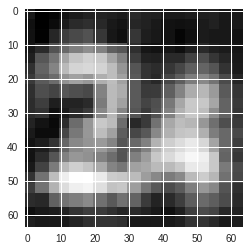

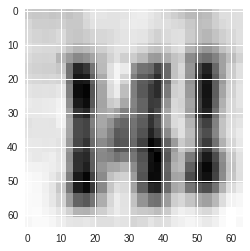

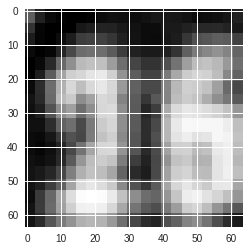

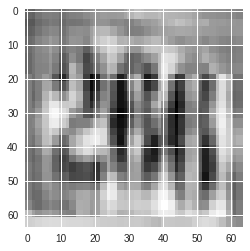

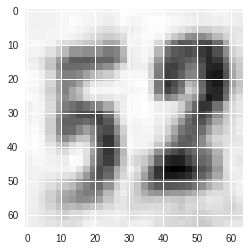

In [46]:
# Printing some examples of real and predicted labels
for i in random.sample(range(0,10000),5):
    
    actual_labels = []
    predicted_labels = []
    plt.figure()
    plt.imshow(test_dataset[i])
    for j in range(0,5):
        actual_labels.append(np.argmax(test_labels[j][i]))
        predicted_labels.append(np.argmax(predictions[j][i]))
        
    print("Actual labels: {}".format(actual_labels))
    print("Predicted labels: {}\n".format(predicted_labels))

Source: https://sajalsharma.com/portfolio/digit_sequence_recognition